<a href="https://colab.research.google.com/github/Sloba98/Laundry-Image-Classification/blob/vgg16-base_model_branch/vgg16_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import VGG16_Weights, ResNet50_Weights
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [ ]:
from PIL import Image
from torchvision import transforms

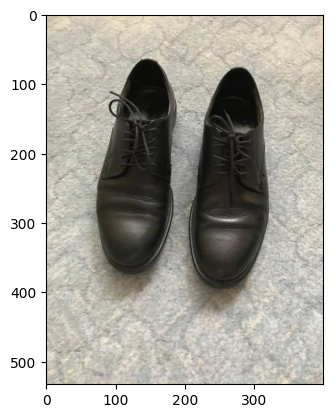

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


path = 'inputs/train/shoes/00f6e504-7c27-438e-a5d7-bc65e557bb2b.jpg'
img = mpimg.imread(path)
imgplot = plt.imshow(img)
plt.show()


In [ ]:
class ImageNetPreprocessing(nn.Module):
    def __init__(self):
        super(ImageNetPreprocessing, self).__init__()
        self.mean = torch.tensor([0.485, 0.456, 0.406])
        self.std = torch.tensor([0.229, 0.224, 0.225])

    def forward(self, x):
        mean = self.mean.to(x.device)
        std = self.std.to(x.device)

        x = x[:, [2, 1, 0], :, :]  # Convert RGB to BGR
        x = (x - mean[None, :, None, None]) / std[None, :, None, None]
        return x

In [ ]:
class VGG16Custom(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16Custom, self).__init__()
        self.vgg16 = models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        for param in self.vgg16.parameters():
            param.requires_grad = False

        self.vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        self.preprocessing = ImageNetPreprocessing()

    def forward(self, x):
        x = self.preprocessing(x)
        x = self.vgg16(x)
        return x

In [ ]:
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
num_classes = 10

vgg16_model = VGG16Custom(num_classes=num_classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16_model.to(device)

print(vgg16_model)

VGG16Custom(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (1

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root='inputs/train', transform=train_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2

In [ ]:
learning_rate = 0.001
optimizer = optim.Adam(vgg16_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(64):

    vgg16_model.train()

    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        accuracy = calculate_accuracy(outputs, labels)
        running_loss += loss.item()
        running_accuracy += accuracy

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = running_accuracy / len(train_loader)
    print(f'Epoch {epoch+1}/20, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch 1/20, Loss: 2.0266, Accuracy: 0.6018
Epoch 2/20, Loss: 0.7909, Accuracy: 0.7981
Epoch 3/20, Loss: 0.7169, Accuracy: 0.8525
Epoch 4/20, Loss: 0.7859, Accuracy: 0.8646


KeyboardInterrupt: 

In [ ]:
def predict_image(model, image_path, transform, device):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension

    # Move image to the appropriate device
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    return predicted.item()

# Example usage
predict_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Predict the class of a new image
image_path = 'inputs/test/shoes/07d88b75-85a4-407b-aa73-12294a2ff9a8.jpg'
predicted_class = predict_image(vgg16_model, image_path, predict_transform, device)
print(f'Predicted class index: {predicted_class}')

Predicted class index: 6
